In [1]:
# # Flight Price Prediction ML Project
#
# This notebook implements a complete machine learning pipeline for predicting flight prices based on various features such as airline, source city, destination city, departure time, etc.
#
# ## Project Structure
# 1. **Import Libraries**
# 2. **Load Dataset**
# 3. **Exploratory Data Analysis (EDA)**
# 4. **Data Preprocessing and Feature Engineering**
# 5. **Model Training and Evaluation**
# 6. **Hyperparameter Tuning (Optional)**
# 7. **Model Saving**
# 8. **Prediction Function**
# 9. **Streamlit App Deployment in Colab**
#
# ### Prerequisites
# - Upload your dataset CSV file to Colab (e.g., 'flight_prices.csv').
# - The dataset should have columns: airline, source_city, departure_time, stops, arrival_time, destination_city, class, duration, days_left, price, flight (optional).
#
# If the dataset is on Google Drive, mount it as shown below.

In [4]:
# Install required libraries in Google Colab
!pip install --upgrade pip
!pip install pandas numpy matplotlib seaborn scikit-learn streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 79.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [streamlit]


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import pickle
import os
from google.colab import drive
import streamlit as st

# Additional imports for completeness
from sklearn.model_selection import cross_val_score

In [7]:
# ## 2. Load Dataset

# Mount Google Drive if dataset is stored there
drive.mount('/content/drive')

# Load the dataset (update the path as needed)
#data_path = '/content/drive/MyDrive/path_to_your_dataset/flight_prices.csv'  # Replace with your actual path
#df = pd.read_csv(data_path)
df=pd.read_csv('flight_prices.csv')

# Display basic info
df.info()

# Drop unnecessary columns if they exist
if 'flight' in df.columns:
    del df['flight']

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


Dataset Information:
Shape: (300153, 11)

Data Types:
Unnamed: 0            int64
airline              object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object

Missing Values:
Unnamed: 0          0
airline             0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

Statistical Summary:
          Unnamed: 0       duration      days_left          price
count  300153.000000  300153.000000  300153.000000  300153.000000
mean   150076.000000      12.221021      26.004751   20889.660523
std     86646.852011       7.191997      13.561004   22697.767366
min         0.000000       0.830000       1.000000    1105.000000


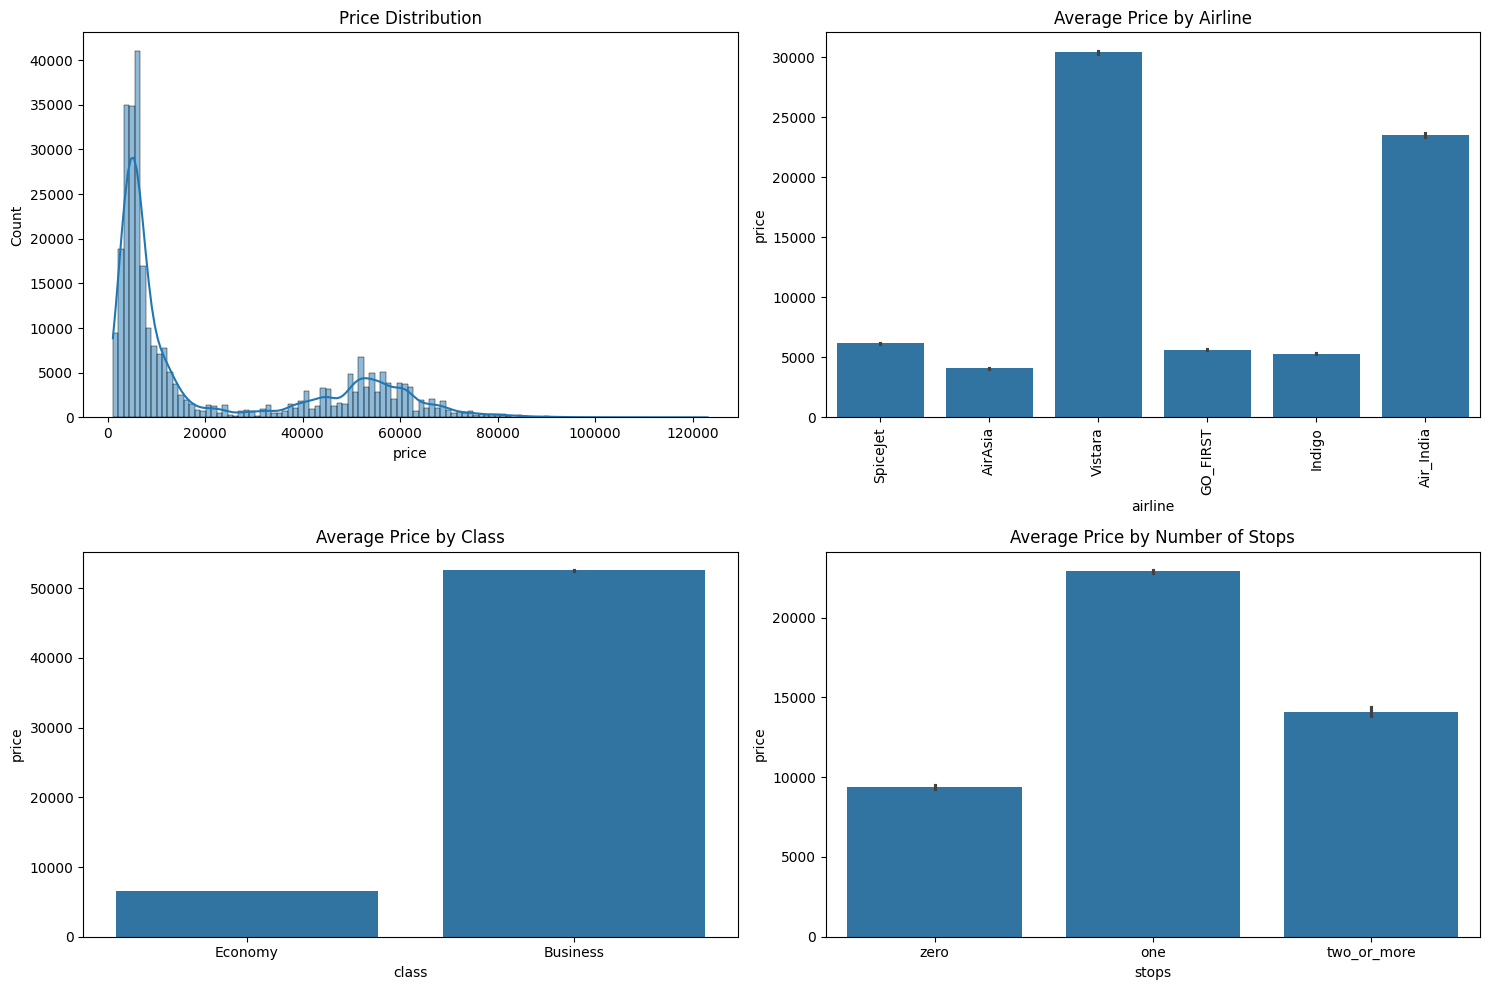

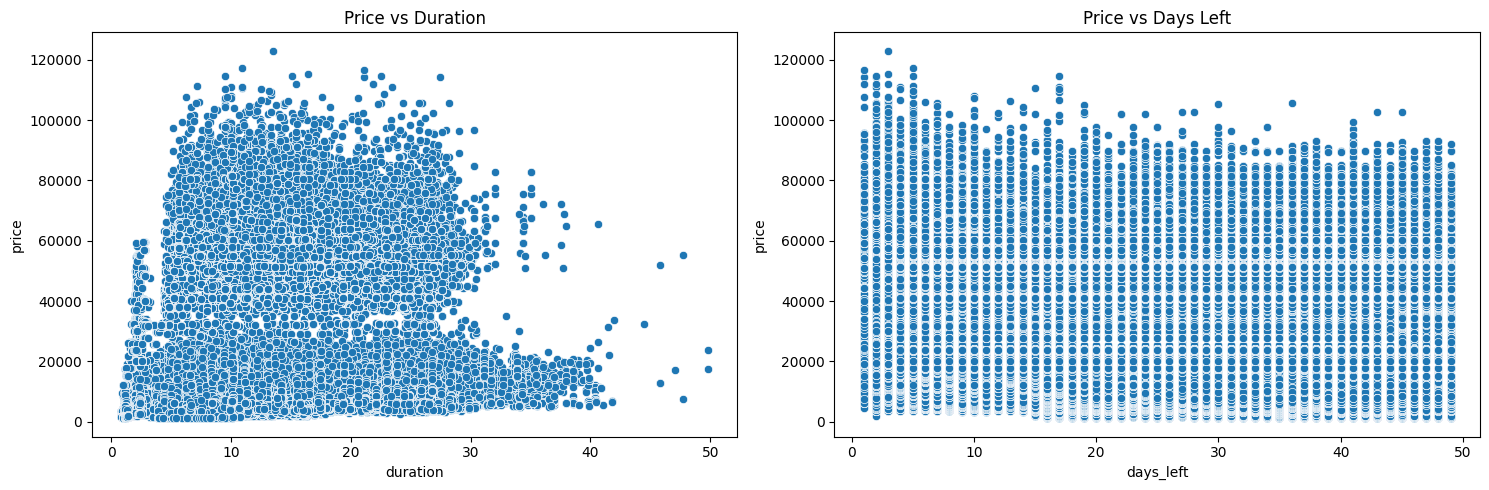

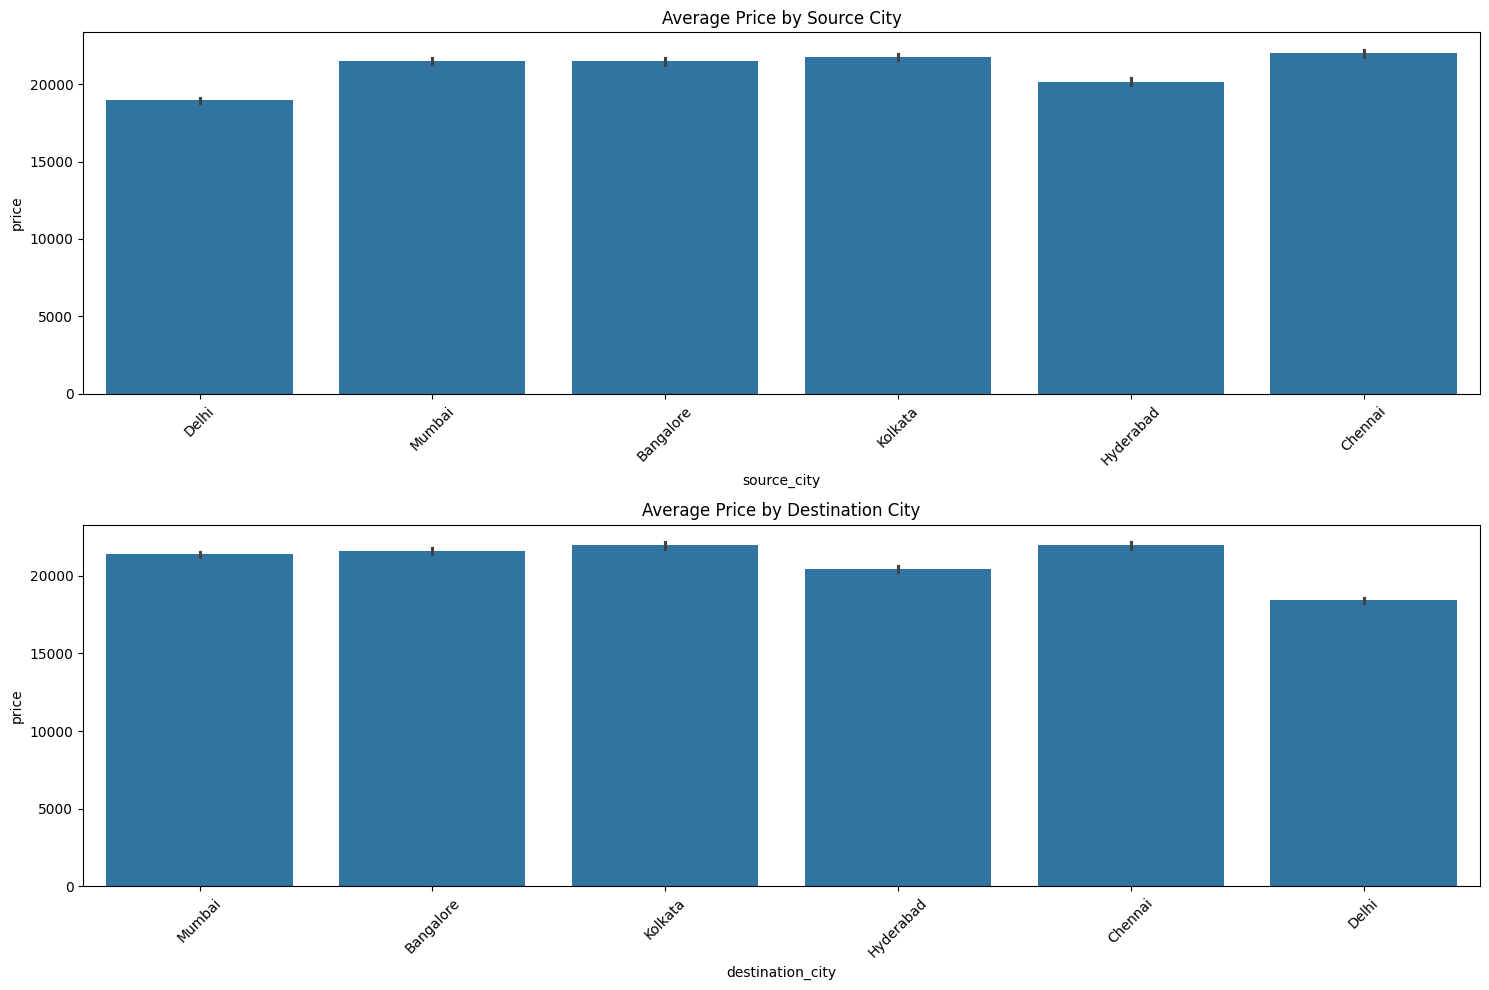

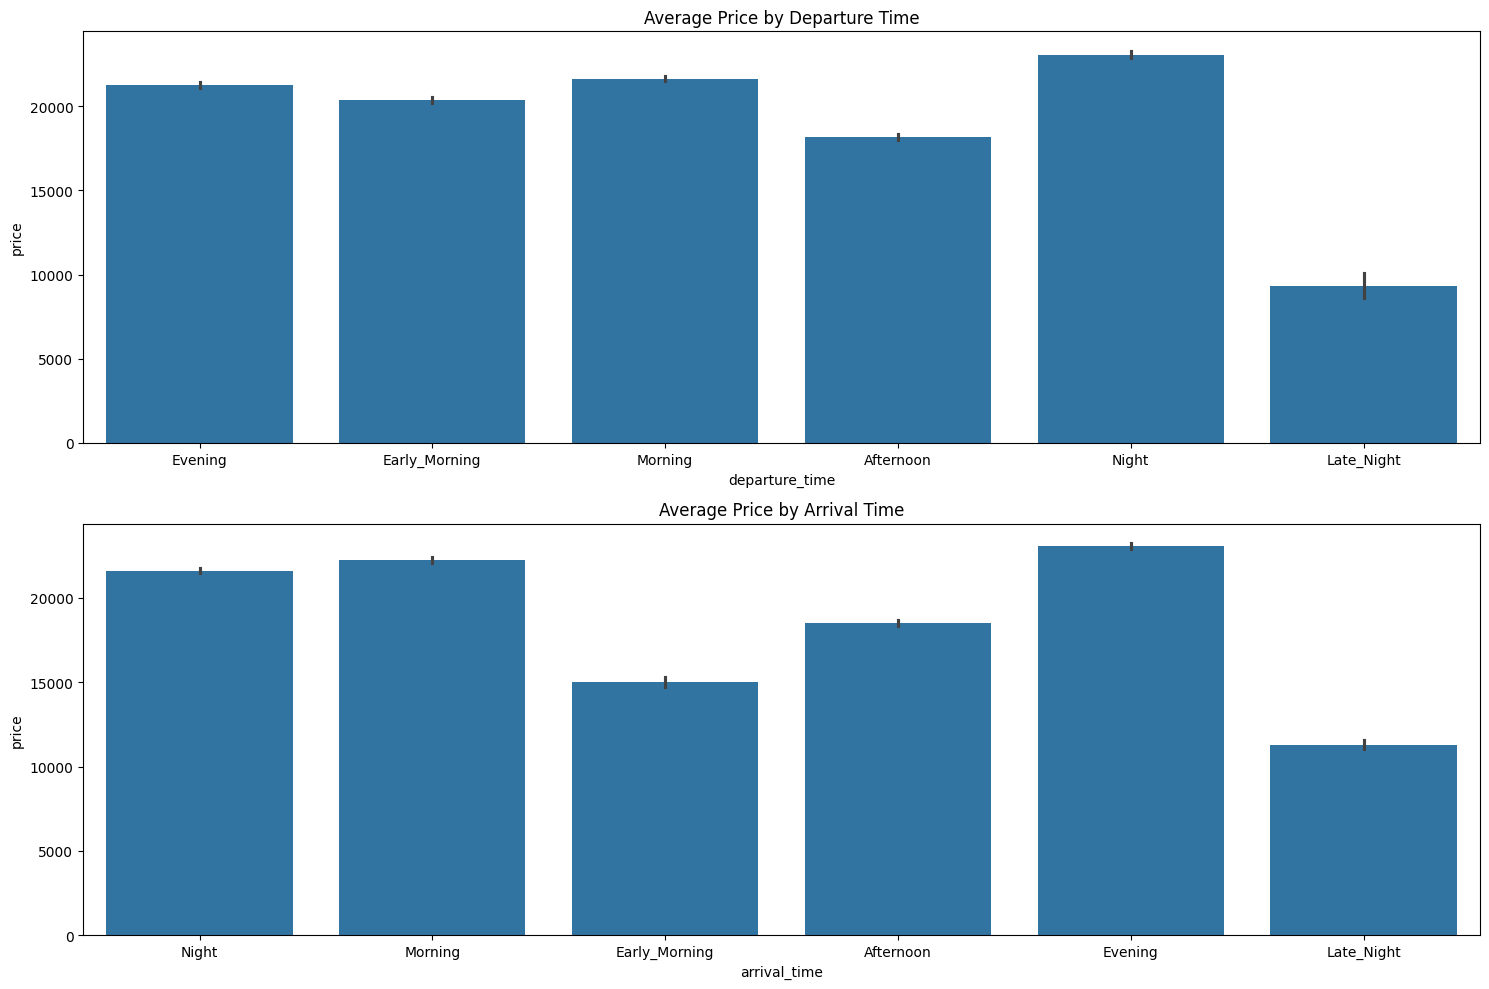

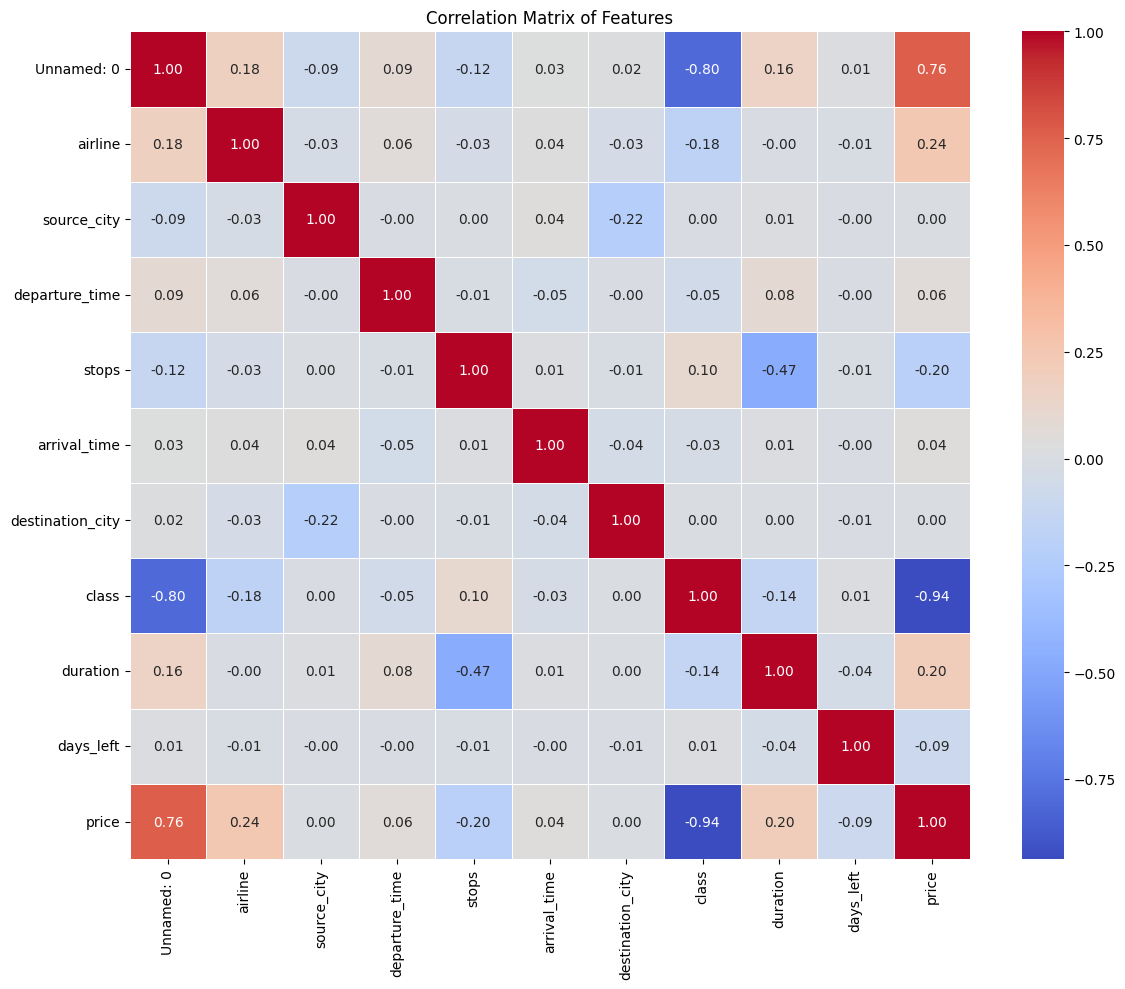


Correlation with Price:
price               1.000000
Unnamed: 0          0.761177
airline             0.243358
duration            0.204222
departure_time      0.058319
arrival_time        0.042043
destination_city    0.004795
source_city         0.004594
days_left          -0.091949
stops              -0.202620
class              -0.937860
Name: price, dtype: float64


In [9]:
# ## 3. Exploratory Data Analysis (EDA)

# Dataset structure
print("Dataset Information:")
print(f"Shape: {df.shape}")
print("\nData Types:")
print(df.dtypes)

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Basic statistical summary
print("\nStatistical Summary:")
print(df.describe())

# Unique values in categorical features
print("\nUnique values in categorical features:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts())
    print("-" * 50)

# Visualizations: Price distribution and relationships
plt.figure(figsize=(15, 10))

# Price distribution
plt.subplot(2, 2, 1)
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')

# Average price by airline
plt.subplot(2, 2, 2)
sns.barplot(x='airline', y='price', data=df, estimator=np.mean)
plt.title('Average Price by Airline')
plt.xticks(rotation=90)

# Average price by class
plt.subplot(2, 2, 3)
sns.barplot(x='class', y='price', data=df, estimator=np.mean)
plt.title('Average Price by Class')

# Average price by stops
plt.subplot(2, 2, 4)
sns.barplot(x='stops', y='price', data=df, estimator=np.mean)
plt.title('Average Price by Number of Stops')

plt.tight_layout()
plt.show()

# Price vs numerical features
plt.figure(figsize=(15, 5))

# Price vs Duration
plt.subplot(1, 2, 1)
sns.scatterplot(x='duration', y='price', data=df)
plt.title('Price vs Duration')

# Price vs Days Left
plt.subplot(1, 2, 2)
sns.scatterplot(x='days_left', y='price', data=df)
plt.title('Price vs Days Left')

plt.tight_layout()
plt.show()

# Price by source and destination city
plt.figure(figsize=(15, 10))

# Average price by source city
plt.subplot(2, 1, 1)
sns.barplot(x='source_city', y='price', data=df, estimator=np.mean)
plt.title('Average Price by Source City')
plt.xticks(rotation=45)

# Average price by destination city
plt.subplot(2, 1, 2)
sns.barplot(x='destination_city', y='price', data=df, estimator=np.mean)
plt.title('Average Price by Destination City')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Price by departure and arrival time
plt.figure(figsize=(15, 10))

# Average price by departure time
plt.subplot(2, 1, 1)
sns.barplot(x='departure_time', y='price', data=df, estimator=np.mean)
plt.title('Average Price by Departure Time')

# Average price by arrival time
plt.subplot(2, 1, 2)
sns.barplot(x='arrival_time', y='price', data=df, estimator=np.mean)
plt.title('Average Price by Arrival Time')

plt.tight_layout()
plt.show()

# Correlation matrix
df_encoded = df.copy()
categorical_cols = df_encoded.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
label_encoders = {}  # Store encoders for later use

for col in categorical_cols:
    label_encoders[col] = label_encoder.fit(df_encoded[col])
    df_encoded[col] = label_encoders[col].transform(df_encoded[col])

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

price_correlation = correlation_matrix['price'].sort_values(ascending=False)
print("\nCorrelation with Price:")
print(price_correlation)

In [18]:
# ## 4. Data Preprocessing and Feature Engineering

# Feature selection based on correlation and EDA
selected_features = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left']
X = df[selected_features]
y = df['price']

# Use Label Encoding consistently (since Gradient Boosting handles it well)
for col in X.select_dtypes(include=['object']).columns:
    if col in label_encoders:
        X[col] = label_encoders[col].transform(X[col])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['duration', 'days_left']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

/tmp/ipython-input-1894300405.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoders[col].transform(X[col])
/tmp/ipython-input-1894300405.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoders[col].transform(X[col])
/tmp/ipython-input-1894300405.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa


Linear Regression:
Mean Squared Error: 49200540.29
Root Mean Squared Error: 7014.31
R² Score: 0.9046

Decision Tree:
Mean Squared Error: 12565051.39
Root Mean Squared Error: 3544.72
R² Score: 0.9756

Random Forest:
Mean Squared Error: 7770500.40
Root Mean Squared Error: 2787.56
R² Score: 0.9849

Gradient Boosting:
Mean Squared Error: 24950509.12
Root Mean Squared Error: 4995.05
R² Score: 0.9516

Best Model: Random Forest with R²: 0.9849

Feature Importance for Random Forest:
            Feature  Importance
6             class    0.879856
7          duration    0.059709
8         days_left    0.018642
0           airline    0.010746
1       source_city    0.010743
5  destination_city    0.009540
4      arrival_time    0.004622
2    departure_time    0.004243
3             stops    0.001899


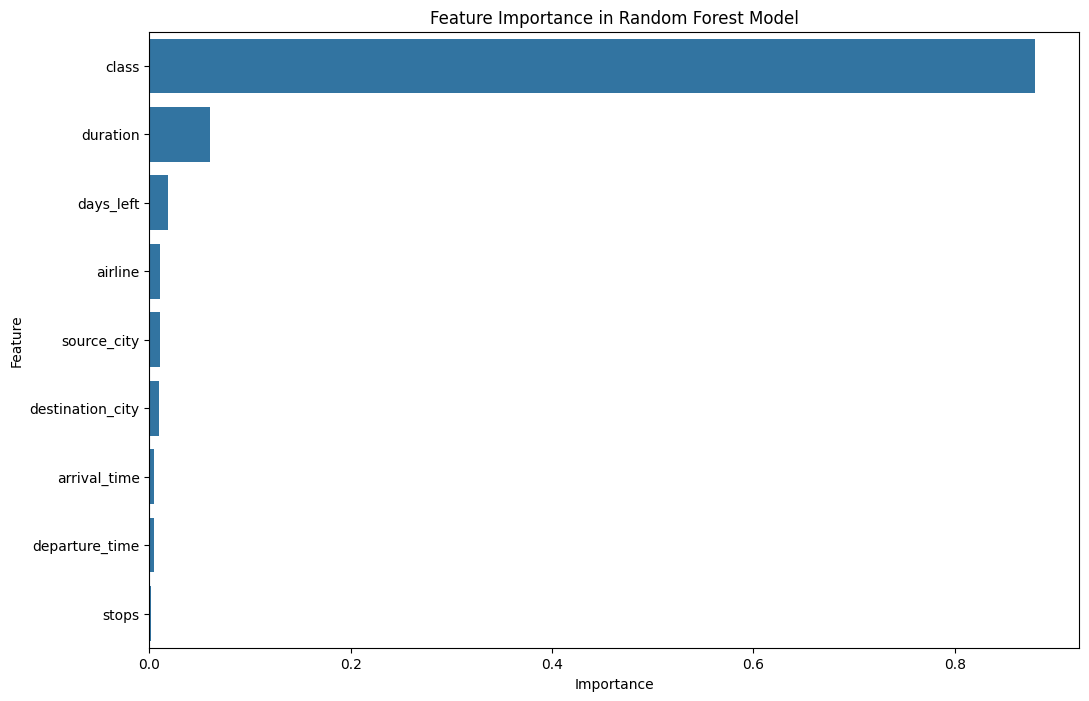

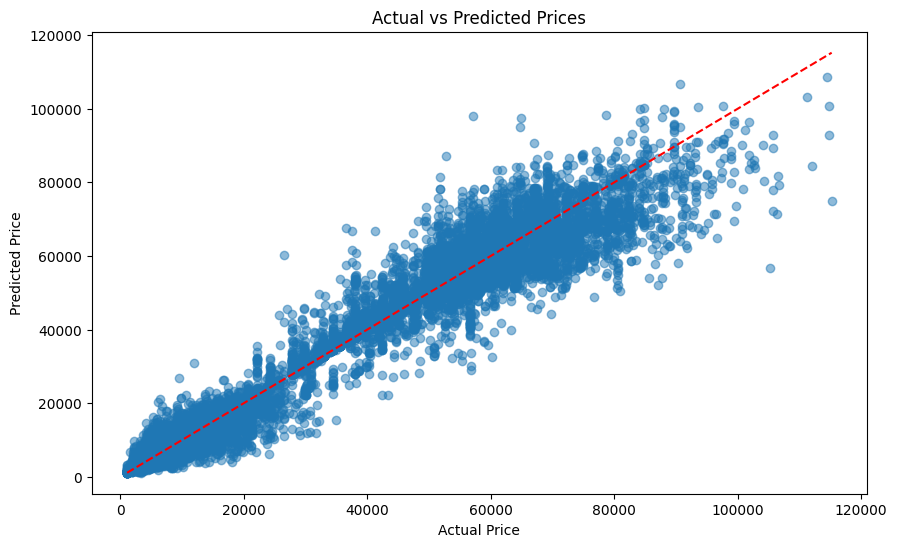

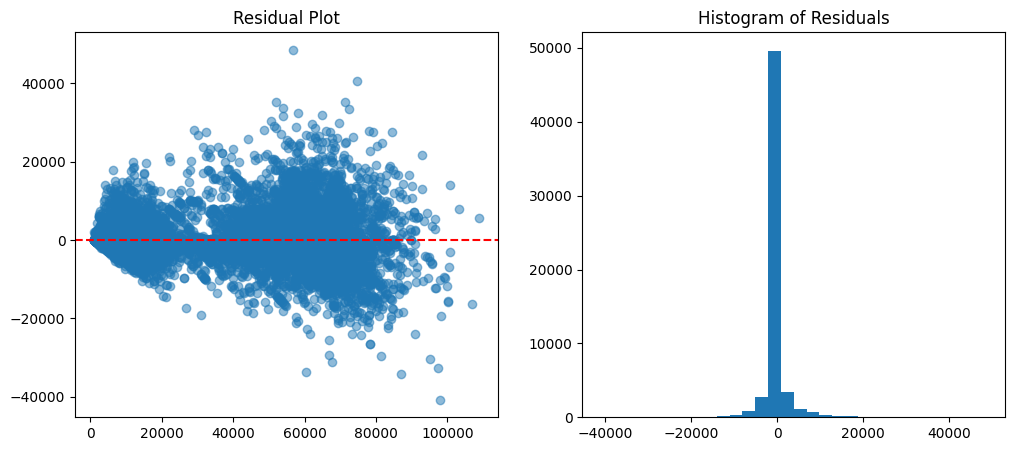


Cross-Validation R² Scores: [0.47183027 0.50433592 0.53408249 0.8639287  0.09747762]
Mean CV R²: 0.4943


In [20]:
# ## 5. Model Training and Evaluation

# Define multiple models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "RMSE": rmse, "R2": r2}
    print(f"\n{name}:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")

# Select the best model (e.g., Gradient Boosting)
best_model_name = max(results, key=lambda x: results[x]["R2"])
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name} with R²: {results[best_model_name]['R2']:.4f}")

# Feature Importance (for tree-based model)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print(f"\nFeature Importance for {best_model_name}:")
    print(feature_importance)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Feature Importance in {best_model_name} Model')
    plt.show()

# Actual vs Predicted
y_pred = best_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()

# Residuals Analysis
residuals = y_test - y_pred
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.show()

# Cross-validation for best model
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print(f"\nCross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f}")

In [ ]:
# ## 6. Hyperparameter Tuning (Optional)

# Example for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)
print(f"Best Params: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Re-evaluate
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Tuned R²: {r2:.4f}")

In [22]:
# ## 7. Model Saving

save_path = '/content/drive/MyDrive/flight_price_prediction'
os.makedirs(save_path, exist_ok=True)

model_path = os.path.join(save_path, 'best_model.pkl')
with open(model_path, 'wb') as file:
    pickle.dump(best_model, file)

encoders_path = os.path.join(save_path, 'label_encoders.pkl')
with open(encoders_path, 'wb') as file:
    pickle.dump(label_encoders, file)

scaler_path = os.path.join(save_path, 'scaler.pkl')
with open(scaler_path, 'wb') as file:
    pickle.dump(scaler, file)

print(f"Model saved to: {model_path}")
print(f"Label encoders saved to: {encoders_path}")
print(f"Scaler saved to: {scaler_path}")

Model saved to: /content/drive/MyDrive/flight_price_prediction/best_model.pkl
Label encoders saved to: /content/drive/MyDrive/flight_price_prediction/label_encoders.pkl
Scaler saved to: /content/drive/MyDrive/flight_price_prediction/scaler.pkl


In [23]:
# ## 8. Prediction Function

def load_and_predict(airline, source_city, departure_time, stops, arrival_time,
                    destination_city, class_type, duration, days_left):
    with open('/content/drive/MyDrive/flight_price_prediction/best_model.pkl', 'rb') as file:
        loaded_model = pickle.load(file)

    with open('/content/drive/MyDrive/flight_price_prediction/label_encoders.pkl', 'rb') as file:
        loaded_encoders = pickle.load(file)

    with open('/content/drive/MyDrive/flight_price_prediction/scaler.pkl', 'rb') as file:
        loaded_scaler = pickle.load(file)

    new_data = pd.DataFrame({
        'airline': [airline],
        'source_city': [source_city],
        'departure_time': [departure_time],
        'stops': [stops],
        'arrival_time': [arrival_time],
        'destination_city': [destination_city],
        'class': [class_type],
        'duration': [duration],
        'days_left': [days_left]
    })

    for col in new_data.select_dtypes(include=['object']).columns:
        if col in loaded_encoders:
            new_data[col] = loaded_encoders[col].transform(new_data[col])

    new_data[numerical_cols] = loaded_scaler.transform(new_data[numerical_cols])

    predicted_price = loaded_model.predict(new_data)[0]
    return predicted_price

# Example usage
predicted_price = load_and_predict("SpiceJet", "Delhi", "Morning", "zero", "Afternoon", "Mumbai", "Economy", 2.5, 30)
print(f'Predicted price: {predicted_price:.2f}')

Predicted price: 3609.43


In [27]:
# ## 9. Streamlit App Deployment in Colab
#
# Note: This runs the Streamlit app within Colab using localtunnel for public access.
# Follow these steps:
# 1. Run the cell to install dependencies, write the app, and start the services.
# 2. Note the Colab IP from the curl command.
# 3. Note the localtunnel URL (e.g., https://your-subdomain.loca.lt).
# 4. Visit the localtunnel URL in your browser and enter the Colab IP when prompted to access the app.

# Install Streamlit
!pip install streamlit -q

# Write Streamlit app code to a file
app_code = """
import streamlit as st
import pandas as pd
import pickle

@st.cache_resource
def load_model():
    with open('/content/drive/MyDrive/flight_price_prediction/best_model.pkl', 'rb') as file:
        model = pickle.load(file)
    with open('/content/drive/MyDrive/flight_price_prediction/label_encoders.pkl', 'rb') as file:
        label_encoders = pickle.load(file)
    with open('/content/drive/MyDrive/flight_price_prediction/scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)
    return model, label_encoders, scaler

model, label_encoders, scaler = load_model()

st.set_page_config(page_title="Flight Price Predictor", page_icon="✈️", layout="wide")
st.title("✈️ Flight Price Prediction App")
st.markdown("This app predicts flight prices based on various parameters using a machine learning model.")

with st.form("prediction_form"):
    col1, col2, col3 = st.columns(3)
    with col1:
        airline = st.selectbox("Airline", list(label_encoders['airline'].classes_))
        source_city = st.selectbox("Source City", list(label_encoders['source_city'].classes_))
        destination_city = st.selectbox("Destination City", list(label_encoders['destination_city'].classes_))
    with col2:
        departure_time = st.selectbox("Departure Time", list(label_encoders['departure_time'].classes_))
        arrival_time = st.selectbox("Arrival Time", list(label_encoders['arrival_time'].classes_))
        stops = st.selectbox("Stops", list(label_encoders['stops'].classes_))
    with col3:
        class_type = st.selectbox("Class", list(label_encoders['class'].classes_))
        duration = st.number_input("Duration (hours)", min_value=0.5, max_value=24.0, value=2.5, step=0.1)
        days_left = st.slider("Days Left Before Departure", min_value=1, max_value=100, value=30)
    submit_button = st.form_submit_button("Predict Price")

if submit_button:
    if source_city == destination_city:
        st.error("Source and destination cities cannot be the same!")
    else:
        input_data = pd.DataFrame({'airline': [airline], 'source_city': [source_city], 'departure_time': [departure_time],
                                   'stops': [stops], 'arrival_time': [arrival_time], 'destination_city': [destination_city],
                                   'class': [class_type], 'duration': [duration], 'days_left': [days_left]})
        for col in input_data.select_dtypes(include=['object']).columns:
            if col in label_encoders:
                input_data[col] = label_encoders[col].transform(input_data[col])
        input_data[['duration', 'days_left']] = scaler.transform(input_data[['duration', 'days_left']])
        price_prediction = model.predict(input_data)[0]
        st.success(f"Predicted Flight Price: ₹{price_prediction:,.2f}")
"""

with open("app.py", "w") as f:
    f.write(app_code)

# Install localtunnel
!npm install -g localtunnel

# Get Colab's public IP address (this is the 'password' to enter in the localtunnel webpage)
!curl ipv4.icanhazip.com

# Run Streamlit in the background
!streamlit run app.py &>/dev/null&

# Run localtunnel to expose port 8501 (Streamlit's default port)
!lt --port 8501

⠙⠹⠸⠼⠴⠦
changed 22 packages in 850ms
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦34.139.20.239
your url is: https://brave-mammals-change.loca.lt
^C
